# Import important libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from brainflow.data_filter import DataFilter, FilterTypes, AggOperations, WindowFunctions, DetrendOperations

# Import BP and Questionnaire datasets

In [2]:
external_data = pd.read_excel('External Data.xlsx')
form_data = pd.read_excel('Responses.xlsx')

# Filtering and Power Spectral Density calculation 

In [3]:
ch0_alpha_band_powers = []
ch1_alpha_band_powers = []

ch0_beta_band_powers = []
ch1_beta_band_powers = []

ch0_gamma_band_powers = []
ch1_gamma_band_powers = []

ch0_theta_band_powers = []
ch1_theta_band_powers = []

eeg_data_list = ['A001','A002','A003','A004','A005','A006','G001','G002','G003','G004','G005','G006','G007','H001','H002','H003','H004','H005']

In [4]:
# Filtering Procedure that applies gain cancellation, 3rd order high and low pass filters, rms voltage conversion

def filtering(channel_data):
    channel_data = channel_data/24
    for i in range(3):
        DataFilter.perform_highpass(channel_data, 250, 0.3, 4, FilterTypes.BUTTERWORTH.value, 0) #3rd order HP filter
        DataFilter.perform_lowpass(channel_data, 250, 95.0, 5, FilterTypes.CHEBYSHEV_TYPE_1.value, 1) #3rd order LP filter
    channel_data = channel_data*0.707 # RMS Voltage
    return channel_data

In [5]:
# Calculating power bands by estimating PSD  

def power_bands(channel_data, detrend, channel_number):
    if(detrend == 1):
        DataFilter.detrend(channel_data, DetrendOperations.LINEAR.value)
    nfft = DataFilter.get_nearest_power_of_two(250)
    psd = DataFilter.get_psd_welch(channel_data, nfft, nfft//2, 250, WindowFunctions.BLACKMAN_HARRIS.value)
    band_power_alpha = DataFilter.get_band_power(psd, 8.0, 13.0)
    band_power_beta = DataFilter.get_band_power(psd, 14.0, 30.0)
    band_power_gamma = DataFilter.get_band_power(psd, 30.0, 95.0)
    band_power_theta = DataFilter.get_band_power(psd, 4.0, 7.5)
    if(channel_number == 0):
        ch0_alpha_band_powers.append(band_power_alpha)
        ch0_beta_band_powers.append(band_power_beta)
        ch0_gamma_band_powers.append(band_power_gamma)
        ch0_theta_band_powers.append(band_power_theta)
    if(channel_number == 1):
        ch1_alpha_band_powers.append(band_power_alpha)
        ch1_beta_band_powers.append(band_power_beta)
        ch1_gamma_band_powers.append(band_power_gamma)
        ch1_theta_band_powers.append(band_power_theta)
    return 0

In [6]:
# Driver code to get band powers of all the datasets
# Note: Filename H005_RELAX.csv was not stopped exactly at 2 minutes hence initial 30,000 rows are to be selected (as 2 min data)

for i in range(len(eeg_data_list)):
    file_name = eeg_data_list[i]+'_RELAX.csv'
    eeg_data = pd.read_csv(file_name)
    if(file_name == 'H005_RELAX.csv'):
        channel_data = filtering(eeg_data[' EXG Channel 0'].iloc[:30000].values)
        dataset1 = pd.DataFrame(data = channel_data, columns = ['ch0'])
        channel_data = filtering(eeg_data[' EXG Channel 1'].iloc[:30000].values)
        dataset1['ch1'] = pd.DataFrame(data = channel_data)
    else:
        channel_data = filtering(eeg_data[' EXG Channel 0'].values)
        dataset1 = pd.DataFrame(data = channel_data, columns = ['ch0'])
        channel_data = filtering(eeg_data[' EXG Channel 1'].values)
        dataset1['ch1'] = pd.DataFrame(data = channel_data)
        
    deleterows = dataset1[(dataset1['ch0'] < -100) | (dataset1['ch0'] > 100) | (dataset1['ch1'] < -100) | (dataset1['ch1']> 100)]
    dataset1 = dataset1.drop(deleterows.index)
    power_bands(dataset1['ch0'].values, 1, 0)
    power_bands(dataset1['ch1'].values, 1, 1)

In [7]:
# Checking that the number of elements in each list is equal to the number of subjects (18)

print(
    len(ch0_alpha_band_powers),
    len(ch0_beta_band_powers),
    len(ch0_gamma_band_powers),
    len(ch0_theta_band_powers),
    len(ch1_alpha_band_powers),
    len(ch1_beta_band_powers),
    len(ch1_gamma_band_powers),
    len(ch1_theta_band_powers)
)

18 18 18 18 18 18 18 18


# Data Preparation for EDA

In [8]:
# Merging the two datasets of BP reading and form responses

dataset = pd.merge(external_data, form_data, left_on = 'Key', right_on = 'C18').drop(['Position of sub','Timestamp','C17','C18'], axis=1)

In [9]:
# Adding the list of psd values to the dataset

dataset['Alpha_ch0'] = pd.DataFrame(data = ch0_alpha_band_powers)
dataset['Beta_ch0'] = pd.DataFrame(data = ch0_beta_band_powers)
dataset['Gamma_ch0'] = pd.DataFrame(data = ch0_gamma_band_powers)
dataset['Theta_ch0'] = pd.DataFrame(data = ch0_theta_band_powers)
dataset['Alpha_ch1'] = pd.DataFrame(data = ch1_alpha_band_powers)
dataset['Beta_ch1'] = pd.DataFrame(data = ch1_beta_band_powers)
dataset['Gamma_ch1'] = pd.DataFrame(data = ch1_gamma_band_powers)
dataset['Theta_ch1'] = pd.DataFrame(data = ch1_theta_band_powers)

In [10]:
dataset = dataset.drop(['C1','C2','C3','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13','C14','C15','C16'], axis = 1)

In [11]:
dataset.head()

,Key,Age,occupation,SYS Init mmHg,DIA Init mmHg,Pulse/Minute Init,SYS Fin mmHg,DIA Fin mmHg,Pulse/Minute Fin,Score,Label,Alpha_ch0,Beta_ch0,Gamma_ch0,Theta_ch0,Alpha_ch1,Beta_ch1,Gamma_ch1,Theta_ch1
0,A001,22,Student,123,73,69,111,80,67,15,Moderate,0.005531,0.004847,1.136505,0.011296,0.012324,0.006984,32.074403,0.044574
1,A002,17,Student,121,85,61,129,111,72,2,Low,0.018448,0.052643,3.735694,0.049332,0.048591,0.244664,22.915736,0.080897
2,A003,17,Student,105,81,82,108,78,82,23,Moderate,0.003125,0.007356,0.380454,0.003087,0.003143,0.007402,0.381705,0.003104
3,A004,48,Other,144,98,75,136,93,66,11,Low,0.065509,0.039125,8.919630,0.468833,0.065519,0.039149,8.929945,0.468574
4,A005,42,Other,117,81,69,114,80,68,17,Moderate,0.001279,0.000355,0.277967,0.011772,0.001435,0.000547,0.305976,0.011679


In [12]:
# Saving the data prepared into a file

dataset.to_csv('EDA_dataset.csv')

In [13]:
dataset = pd.read_csv('EDA_dataset.csv')

In [14]:
fresh_data = dataset.drop(['Unnamed: 0','Key','occupation'], axis = 1)

In [15]:
fresh_data['SYS Diff'] = fresh_data['SYS Fin mmHg'] - fresh_data['SYS Init mmHg']
fresh_data['DIA Diff'] = fresh_data['DIA Fin mmHg'] - fresh_data['DIA Init mmHg']
fresh_data['Pulse Diff'] = fresh_data['Pulse/Minute Fin'] - fresh_data[' Pulse/Minute Init']
fresh_data['Alpha/Beta Ch0'] = fresh_data['Alpha_ch0']/fresh_data['Beta_ch0']
fresh_data['Alpha/Beta Ch1'] = fresh_data['Alpha_ch1']/fresh_data['Beta_ch1']
fresh_data['Beta/Gamma Ch0'] = fresh_data['Beta_ch0']/fresh_data['Gamma_ch0']
fresh_data['Beta/Gamma Ch1'] = fresh_data['Beta_ch1']/fresh_data['Gamma_ch1']
fresh_data['Beta/Theta Ch0'] = fresh_data['Beta_ch0']/fresh_data['Theta_ch0']
fresh_data['Beta/Theta Ch1'] = fresh_data['Beta_ch1']/fresh_data['Theta_ch1']
fresh_data['Theta/Alpha Ch0'] = fresh_data['Theta_ch0']/fresh_data['Alpha_ch0']
fresh_data['Theta/Alpha Ch1'] = fresh_data['Theta_ch1']/fresh_data['Alpha_ch1']
fresh_data = fresh_data.drop(['SYS Init mmHg',
       'DIA Init mmHg', ' Pulse/Minute Init', 'SYS Fin mmHg', 'DIA Fin mmHg','Pulse/Minute Fin','Alpha_ch0', 'Beta_ch0',
       'Gamma_ch0', 'Alpha_ch1', 'Beta_ch1', 'Gamma_ch1', 'Theta_ch0','Theta_ch1'], axis = 1)

In [16]:
copy = fresh_data

In [17]:
delete_rows = copy[(copy['Alpha/Beta Ch0']>2.0) | (copy['Beta/Gamma Ch0']>0.4) | (copy['Beta/Gamma Ch1']>0.5) | (copy['Theta/Alpha Ch0']>4) | (copy['Theta/Alpha Ch1']>7)]

In [18]:
copy = copy.drop(delete_rows.index)

# Feature Selection from correlation graph

In [19]:
copy.corr()

,Age,Score,SYS Diff,DIA Diff,Pulse Diff,Alpha/Beta Ch0,Alpha/Beta Ch1,Beta/Gamma Ch0,Beta/Gamma Ch1,Beta/Theta Ch0,Beta/Theta Ch1,Theta/Alpha Ch0,Theta/Alpha Ch1
Age,1.000000,0.368898,-0.251009,-0.396873,-0.618251,0.005514,-0.076777,-0.523504,-0.456108,0.205263,0.047951,-0.250388,-0.215742
Score,0.368898,1.000000,-0.029104,-0.546617,-0.252931,0.264054,0.201674,-0.018336,0.071134,-0.084985,-0.382179,-0.237291,-0.006999
SYS Diff,-0.251009,-0.029104,1.000000,0.552780,0.418333,-0.515701,-0.519365,0.199722,0.150592,0.064648,0.240791,0.182906,-0.083053
DIA Diff,-0.396873,-0.546617,0.552780,1.000000,0.321640,-0.187771,-0.058474,0.152246,-0.029742,-0.050212,0.210194,0.243058,0.060425
Pulse Diff,-0.618251,-0.252931,0.418333,0.321640,1.000000,-0.039699,-0.196455,0.318835,0.322227,-0.420014,-0.168125,0.503393,0.130504
Alpha/Beta Ch0,0.005514,0.264054,-0.515701,-0.187771,-0.039699,1.000000,0.915287,-0.161925,-0.232866,-0.773842,-0.905801,0.413676,0.660718
Alpha/Beta Ch1,-0.076777,0.201674,-0.519365,-0.058474,-0.196455,0.915287,1.000000,-0.202566,-0.306314,-0.580775,-0.761590,0.212791,0.645430
Beta/Gamma Ch0,-0.523504,-0.018336,0.199722,0.152246,0.318835,-0.161925,-0.202566,1.000000,0.965158,-0.173942,0.016756,0.163381,-0.081926
Beta/Gamma Ch1,-0.456108,0.071134,0.150592,-0.029742,0.322227,-0.232866,-0.306314,0.965158,1.000000,-0.081162,0.070017,0.015705,-0.249464
Beta/Theta Ch0,0.205263,-0.084985,0.064648,-0.050212,-0.420014,-0.773842,-0.580775,-0.173942,-0.081162,1.000000,0.906034,-0.783854,-0.701471


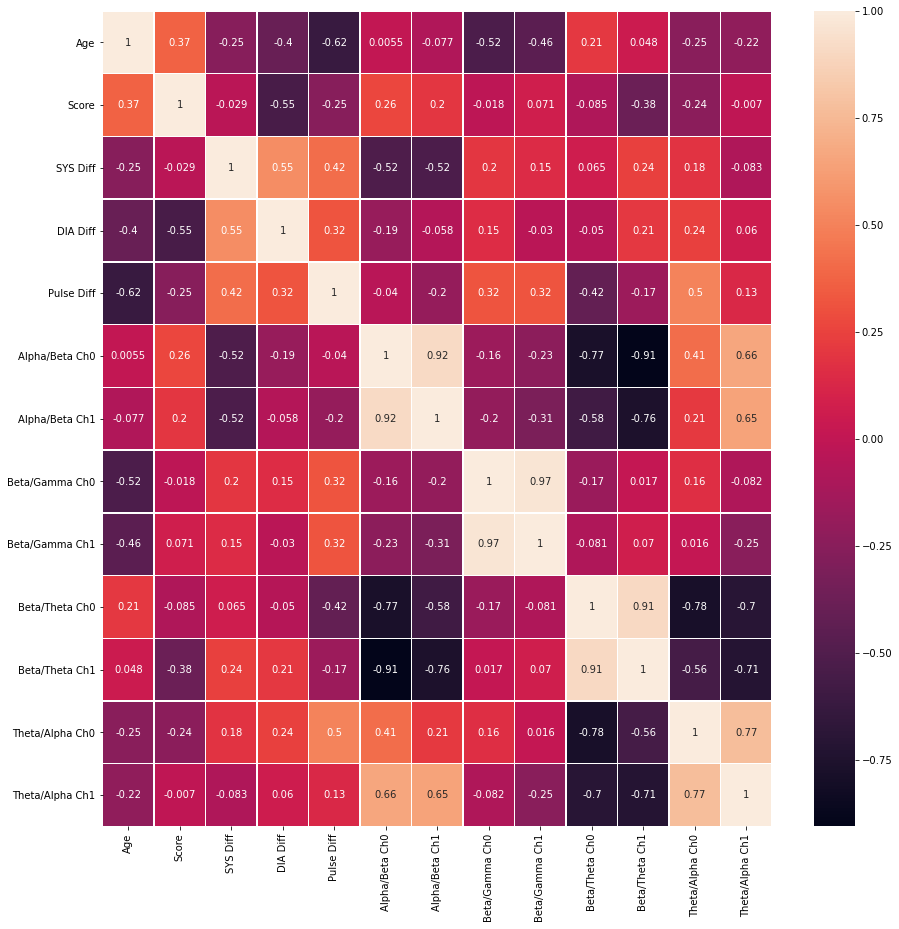

In [20]:
fig, ax = plt.subplots(figsize = (15,15))
sns.heatmap(copy.corr(), annot = True, linewidths = 0.5, ax = ax)

In [21]:
# Saving the data without outliers into a file
# Note: This is optional as the data needed for the next command is already stored in data_for_ML.csv

copy.to_csv('ML_dataset.csv')

# Machine Learning Models

In [22]:
data = pd.read_csv('ML_dataset.csv')

## KNN

In [23]:
from sklearn.model_selection import train_test_split

In [24]:
x = data[['DIA Diff','Beta/Theta Ch1']]
y = data['Label']

In [25]:
x_train, x_test, y_train, y_test = train_test_split(x,y, random_state = 42)

In [26]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 1)

In [27]:
knn.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=1)

In [28]:
knn.score(x_test, y_test)

0.6666666666666666

In [29]:
from sklearn.metrics import confusion_matrix

In [30]:
pred_y = knn.predict(x_test)
confusion_matrix(y_test, pred_y)

array([[0, 0],
       [1, 2]], dtype=int64)

## SVM

In [31]:
x = data[['DIA Diff','Beta/Theta Ch1']]
y = data['Label']
x_train, x_test, y_train, y_test = train_test_split(x,y)

In [32]:
from sklearn.svm import SVC
svm = SVC(kernel = 'linear')

In [33]:
svm.fit(x_train, y_train)

SVC(kernel='linear')

In [34]:
svm.score(x_test, y_test)

1.0

In [35]:
pred_y = knn.predict(x_test)
confusion_matrix(y_test, pred_y)

array([[1, 0],
       [1, 1]], dtype=int64)

# Kernel SVM

### Kernel = Polynomial

In [36]:
svmp = SVC(kernel = 'poly', degree = 0)

In [37]:
svmp.fit(x_train, y_train)

SVC(degree=0, kernel='poly')

In [38]:
svmp.score(x_test, y_test)

0.6666666666666666

In [39]:
pred_y = knn.predict(x_test)
confusion_matrix(y_test, pred_y)

array([[1, 0],
       [1, 1]], dtype=int64)

### Kernel = Gaussian

In [40]:
svmg = SVC(kernel = 'rbf')

In [41]:
svmg.fit(x_train, y_train)

SVC()

In [42]:
svmg.score(x_test, y_test)

0.6666666666666666

In [43]:
pred_y = knn.predict(x_test)
confusion_matrix(y_test, pred_y)

array([[1, 0],
       [1, 1]], dtype=int64)

### Kernel = Sigmoid

In [44]:
svms = SVC(kernel = 'sigmoid')

In [45]:
svms.fit(x_train, y_train)

SVC(kernel='sigmoid')

In [46]:
svms.score(x_test, y_test)

0.6666666666666666

In [47]:
pred_y = knn.predict(x_test)
confusion_matrix(y_test, pred_y)

array([[1, 0],
       [1, 1]], dtype=int64)

# Logistic Regression

In [48]:
x = data[['DIA Diff','Beta/Theta Ch1']]
y = data['Label']
x_train, x_test, y_train, y_test = train_test_split(x,y)

In [49]:
from sklearn.linear_model import LogisticRegression

In [50]:
log_reg = LogisticRegression()

In [51]:
log_reg.fit(x_train, y_train)

LogisticRegression()

In [52]:
log_reg.score(x_test, y_test)

1.0

In [53]:
pred_y = knn.predict(x_test)
confusion_matrix(y_test, pred_y)

array([[3]], dtype=int64)

# Decision Tree Classifier

In [54]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor

In [55]:
dt_model = DecisionTreeClassifier(random_state = 42)

In [56]:
dt_model.fit(x_train, y_train)

DecisionTreeClassifier(random_state=42)

In [57]:
dt_model.score(x_test, y_test)

1.0

In [58]:
pred_y = knn.predict(x_test)
confusion_matrix(y_test, pred_y)

array([[3]], dtype=int64)

#### Note: The performances of above models are dependent on the sample size and random sampling of the data and may vary for each iteration